## EXERCISE 3

Study the data in the file x_XGB_24.dat (N=2000 samples) with labels y_XGB_24.dat. The dataset should be split into N' training samples and N'' validation samples, with N' + N'' = N

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Model

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [13]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
N1=N_train/N
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=N1, random_state=42)
print(f"N={N}, N_train={N_train}, L={L}")


N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


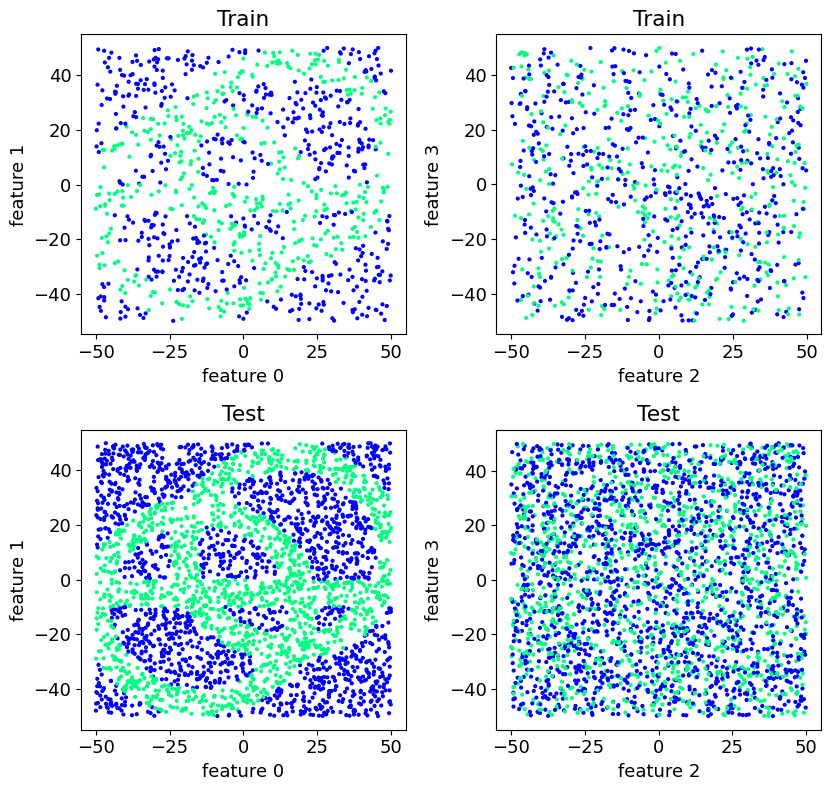

In [14]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_val,y_val,title="Test")
scat(AX[1,1],x_val,y_val,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

### 1\. Model complexity, parameters’ and regularization
Try different parameters (λ, γ, n_estimators, ...). Which is the simplest yet effective XGBoost model that keeps a good validation accuracy? Is regularization useful for this analysis?

In [15]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_val)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_val, y_val)),clf.score(x_val, y_val)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    """
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()
    """

errors: 11.43%   Accuracy=0.886


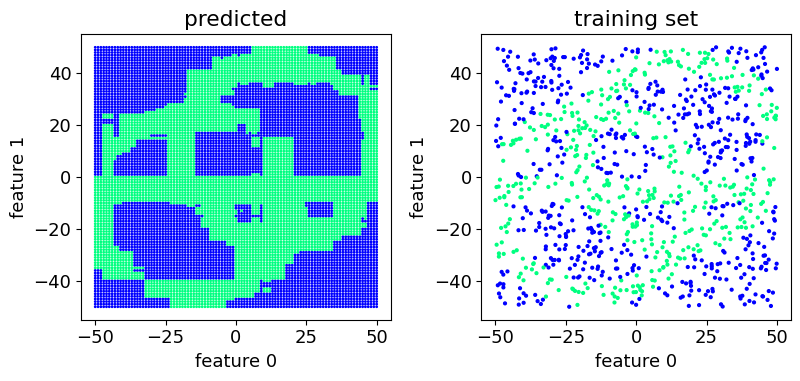

In [16]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic') 
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(model, show=True)

In [17]:
from sklearn.model_selection import GridSearchCV


parameters = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'n_estimators': [10, 50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'reg_lambda': [0.001, 0.01, 0.1, 0],
        'gamma': [0, 0.1, 0.2, 0.3]
    }

model = XGBClassifier(seed=1, objective='binary:logistic')
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=3, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

best_xgb_model =XGBClassifier(**best_params)
best_xgb_model.fit(x_train, y_train)
# Predictions
y_pred = best_xgb_model.predict(x_val)

# Evaluate accuracy
accuracy = accuracy_score(y_train, y_train)
print("Validation Accuracy:", accuracy)



Best Parameters: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 150, 'reg_lambda': 0.01}
Best Accuracy: 0.8209796622970277
Validation Accuracy: 1.0


In [18]:
xgb_model_no_reg = XGBClassifier()
xgb_model_no_reg.fit(x_train, y_train)
y_pred_no_reg = xgb_model_no_reg.predict(x_val)
accuracy_no_reg = accuracy_score(y_val, y_pred_no_reg)
print("Validation Accuracy without Regularization:", accuracy_no_reg)

Validation Accuracy without Regularization: 0.8856666666666667


errors: 10.70%   Accuracy=0.893


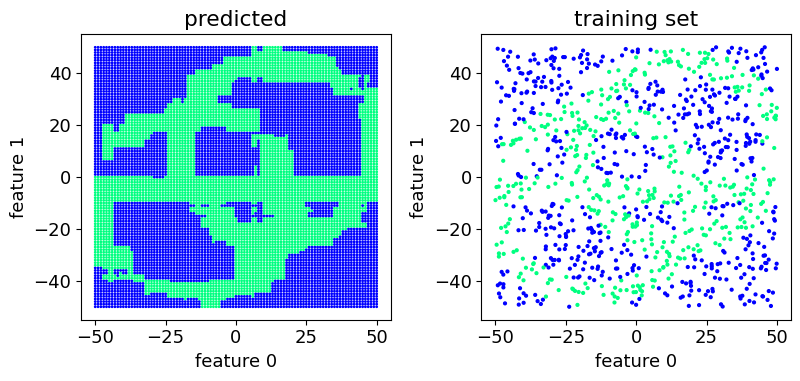

In [19]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
       # importance_type="gain" #weight, cover, ...
       learning_rate=0.1,
       reg_lambda=0.01, 
       n_estimators=200, max_depth=7, gamma=0)

classify(model, show=True)

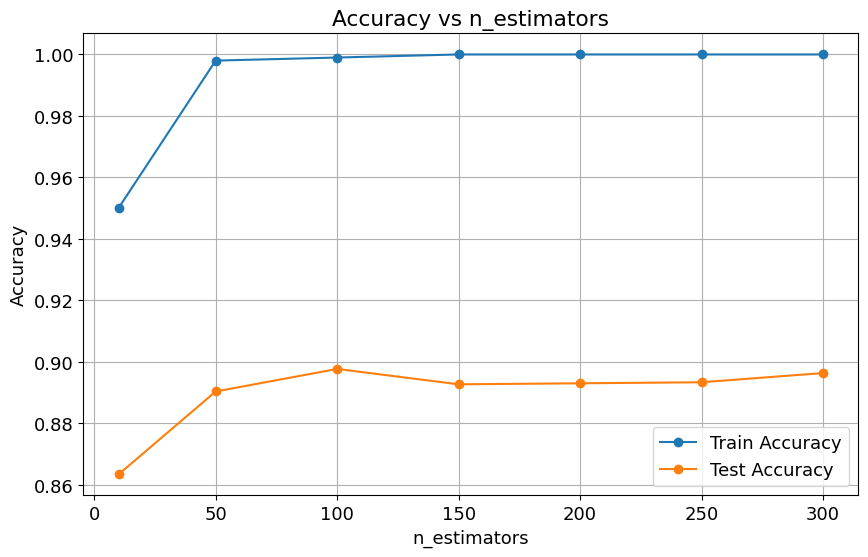

In [20]:
n_estimators_range = [10,50,100,150,200,250,300]
train_accuracies = []
test_accuracies = []

for n_estimators in n_estimators_range:
    model = XGBClassifier(n_estimators=n_estimators, seed=1,
                          objective='binary:logistic',
                          learning_rate=0.1,
                          reg_lambda=0.01,max_depth=7, gamma=0)

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    
    # Calculate train accuracy and store it
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predictions on the test set
    y_test_pred = model.predict(x_val)
    
    # Calculate test accuracy and store it
    test_accuracy = accuracy_score(y_val, y_test_pred)
    test_accuracies.append(test_accuracy)


# Plot accuracy vs n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (9,) and (7,)

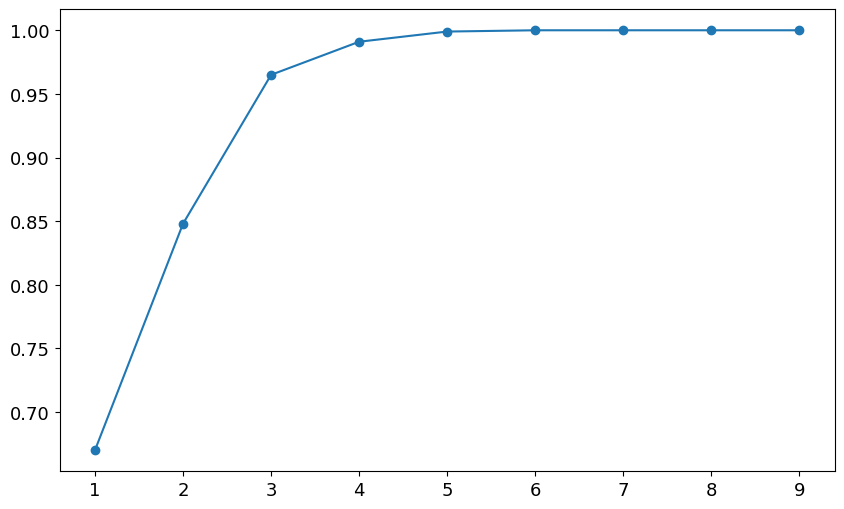

In [21]:

max_dephts_range = [1,2,3,4,5,6,7,8,9]
train_accuracies = []
val_accuracies = []

for max_dephts in max_dephts_range:
    model = XGBClassifier(n_estimators=200, seed=1,
                          objective='binary:logistic',
                          learning_rate=0.1,
                          reg_lambda=0.01, max_depth=max_dephts, gamma=0)

    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    
    # Calculate train accuracy and store it
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predictions on the test set
    y_val_pred = model.predict(x_val)
    
    # Calculate test accuracy and store it
    val_accuracy = accuracy_score(y_val, y_test_pred)
    val_accuracies.append(test_accuracy)


# Plot accuracy vs n_estimators
plt.figure(figsize=(10, 6))
plt.plot(max_dephts_range, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(max_dephts_range, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

errors: 10.43%   Accuracy=0.896


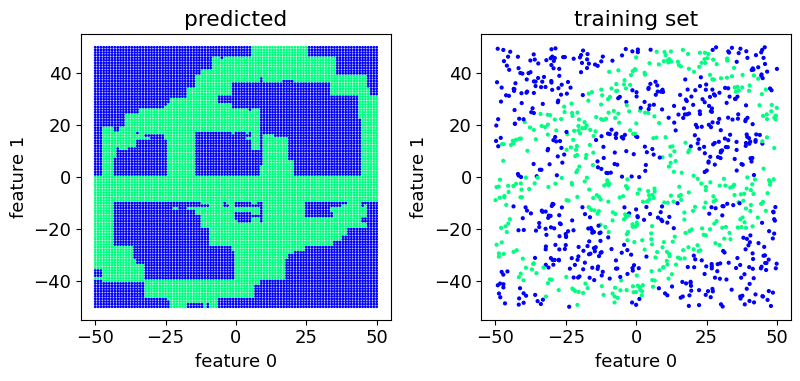

In [22]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
       # importance_type="gain" #weight, cover, ...
       learning_rate=0.1,
       reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)

classify(model, show=True)

### 2\. Dimensionality reduction
Consider reduced data samples with L'\<L features. For example, feature 0,1, and 3 out of the L=4 features. Check if the exclusion of the least important feature(s) from training data leads to better accuracy.

In [23]:
from sklearn.metrics import accuracy_score

# Train the model using the original data with all features
original_model = XGBClassifier(seed=1, objective='binary:logistic',
       learning_rate=0.1,
       reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)
original_model.fit(x_train, y_train)

# Get feature importances
feature_importances = original_model.feature_importances_

# Find the index of the least important feature(s)
least_important_features_indices = 2,3

# Exclude the least important feature(s) from the training data
x_train_reduced = np.delete(x_train, least_important_features_indices, axis=1)

# Retrain the model using the reduced data with L' features
reduced_model = XGBClassifier(seed=1, objective='binary:logistic',learning_rate=0.1,
       reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)
reduced_model.fit(x_train_reduced, y_train)

# Evaluate both models on the test data
y_pred_original = original_model.predict(x_val)
accuracy_original = accuracy_score(y_val, y_pred_original)

y_pred_reduced = reduced_model.predict(np.delete(x_val, least_important_features_indices, axis=1))
accuracy_reduced = accuracy_score(y_val, y_pred_reduced)

print("Accuracy with all features:", accuracy_original)
print("Accuracy with reduced features:", accuracy_reduced)

Accuracy with all features: 0.8956666666666667
Accuracy with reduced features: 0.9226666666666666


Accuracy after removing features [0]: 0.6216666666666667
Accuracy after removing features [1]: 0.5576666666666666
Accuracy after removing features [2]: 0.9103333333333333
Accuracy after removing features [3]: 0.8996666666666666
Accuracy after removing features [0, 1]: 0.523
Accuracy after removing features [1, 2]: 0.5483333333333333
Accuracy after removing features [2, 3]: 0.9226666666666666
Accuracy after removing features [0, 2]: 0.61
Accuracy after removing features [0, 3]: 0.619
Accuracy after removing features [1, 3]: 0.559


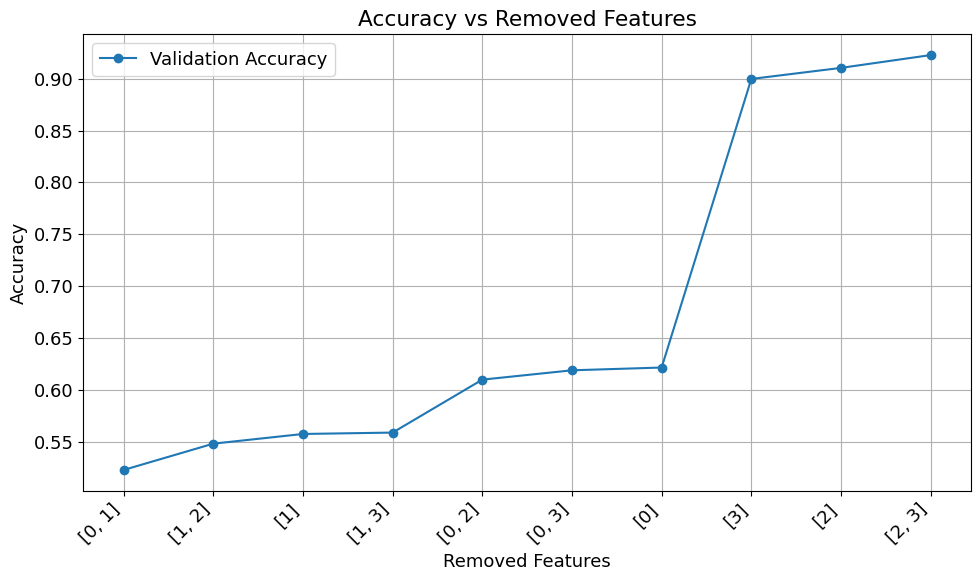

In [24]:
least_important_features_indices = [[0], [1], [2], [3], [0, 1], [1, 2], [2, 3], [0, 2], [0, 3], [1, 3]]
accuracies = []

# Iterate over different sets of least important feature indices
for indices in least_important_features_indices:
    # Exclude the least important feature(s) from the training and testing data
    x_train_reduced = np.delete(x_train, indices, axis=1)
    x_test_reduced = np.delete(x_val, indices, axis=1)

    # Retrain the model using the reduced data with L' features
    reduced_model = XGBClassifier(seed=1, objective='binary:logistic',
                                  learning_rate=0.1,
                                  reg_lambda=0.1, reg_alpha=0.01,
                                  n_estimators=150, max_depth=6, gamma=0)
    reduced_model.fit(x_train_reduced, y_train)
    
    # Predictions on the test set
    y_pred_reduced = reduced_model.predict(x_test_reduced)
    
    # Calculate test accuracy and store it
    accuracy_reduced = accuracy_score(y_val, y_pred_reduced)
    accuracies.append(accuracy_reduced)
    
for i, indices in enumerate(least_important_features_indices):
    print(f"Accuracy after removing features {indices}: {accuracies[i]}")

sorted_indices=sorted(range(len(accuracies)), key=lambda k: accuracies[k])
accuracies=[accuracies[i] for i in sorted_indices]

labels = [str(indices) for indices in least_important_features_indices]
labels=[labels[i] for i in sorted_indices]


# Plot accuracy vs removed features
plt.figure(figsize=(10, 6))
plt.plot(labels, accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs Removed Features')
plt.xlabel('Removed Features')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


### 3\.  XGBoost vs NN
Compare the validation accuracy of XGBoost with that of a simple feed-forward neural network (NN):
- By varying the number of data samples N’ in the training set (i.e., reducing the fraction N’/N of the data set used for training)
- With cross-validation for all cases.

Is the NN or the XGB performing significantly better at low N’?

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

In [35]:
N,L = len(x), len(x[0])
n_class = len(np.unique(y_train))
input_shape = (L, 1)
# Define CNN model using the provided function
def build_model(NF=5, KS=3, NF2=5, KS2=3, lamb=0):
    """
    filter = kernel
    NF=number of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=number of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=lambda, the regularization parameter
    """
    reg = keras.regularizers.l2(lamb)
    model = Sequential()
    model.add(Conv1D(filters=NF, 
                     kernel_size=KS,
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape,
                     padding='same'))  # Ensure output size matches input size
    model.add(Conv1D(filters=NF2, kernel_size=KS2, activation='relu', padding='same'))
    model.add(Conv1D(filters=NF2, kernel_size=KS2, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(n_class, activation='softmax'))
    return model

# Build the model with default parameters
model = build_model()

# Print model summary
model.summary()


c:\Users\primo\OneDrive\Desktop\physics of data\Lab. of Computational Physics (Mod. B)\Ex3\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 4, 5)           │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4, 5)           │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 4, 5)           │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222 (888.00 B)

 Trainable params: 222 (888.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
optimizers = [keras.optimizers.Adam, keras.optimizers.RMSprop, keras.optimizers.SGD, keras.optimizers.Nadam]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
BATCH_SIZE = 200
EPOCHS = 300
results = []

for optimizer in optimizers:
    optimizer_name = optimizer.__name__
    mean_val_accuracies_optimizer = []
    std_val_accuracies_optimizer = []

    for learning_rate in learning_rates:
        opt = optimizer(learning_rate=learning_rate)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Training the model
        fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.2, verbose=0, shuffle=True)
        val_accuracies = fit.history['val_accuracy']

        mean_val_accuracy_lr = np.mean(val_accuracies)
        std_val_accuracy_lr = np.std(val_accuracies)

        mean_val_accuracies_optimizer.append(mean_val_accuracy_lr)
        std_val_accuracies_optimizer.append(std_val_accuracy_lr)

    results.append({
        'optimizer': optimizer_name,
        'learning_rates': learning_rates,
        'mean_val_accuracy': mean_val_accuracies_optimizer,
        'std_val_accuracy': std_val_accuracies_optimizer
    })
print(results)

[{'optimizer': 'Adam', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5935833259423574, 0.5678499958912532, 0.5952666721741359, 0.6272499968608221, 0.5826999878883362], 'std_val_accuracy': [0.011375854121868735, 0.013618389535376252, 0.018464266756664186, 0.022245312330433642, 0.016275031469667686]}, {'optimizer': 'RMSprop', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5849999785423279, 0.5849999785423279, 0.5849999785423279, 0.5849999785423279, 0.5827333120505015], 'std_val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.019498602434596897]}, {'optimizer': 'SGD', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5849999785423279, 0.5849999785423279, 0.5849999785423279, 0.5849999785423279, 0.5849999785423279], 'std_val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0]}, {'optimizer': 'Nadam', 'learning_rates': [1e-05, 0.0001, 0.001, 0.01, 0.1], 'mean_val_accuracy': [0.5849999785423279, 0.5849999785423279, 0.5849999785423279,

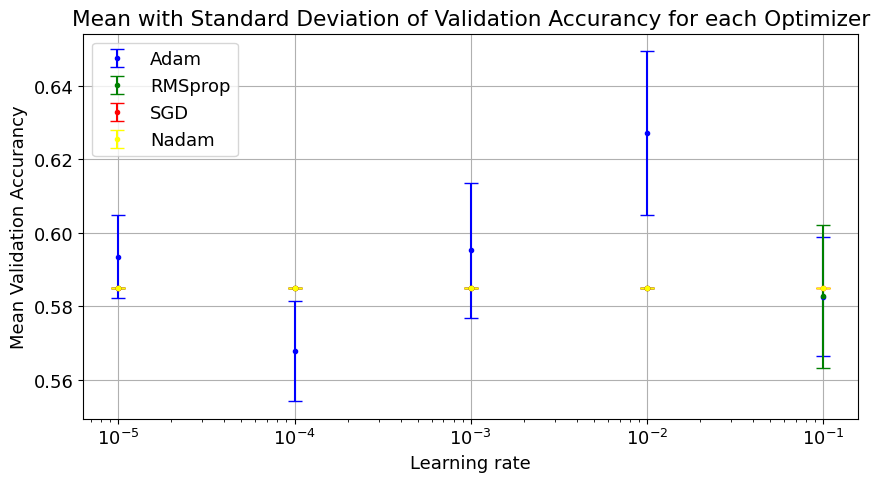

In [28]:
colors = ['blue', 'green', 'red', 'yellow']

plt.figure(figsize=(10, 5))

for i, result in enumerate(results):
    optimizer_name = result['optimizer']
    learning_rates = result['learning_rates']
    mean_val_accuracy = result['mean_val_accuracy']
    std_val_accuracy = result['std_val_accuracy']
    color = colors[i]
    
    
    plt.errorbar(learning_rates, mean_val_accuracy, yerr=std_val_accuracy, fmt='.', capsize=5,label=optimizer_name, color=color)


plt.title('Mean with Standard Deviation of Validation Accurancy for each Optimizer')
plt.xlabel('Learning rate')
plt.ylabel('Mean Validation Accurancy')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Train the model
BATCH_SIZE = 200
EPOCHS = 300
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_split=0.2, verbose=0, shuffle=True)

val_accuracy = fit.history['val_accuracy'][-1]
print(f'Validation Accuracy: {val_accuracy}')

Validation Accuracy: 0.5849999785423279


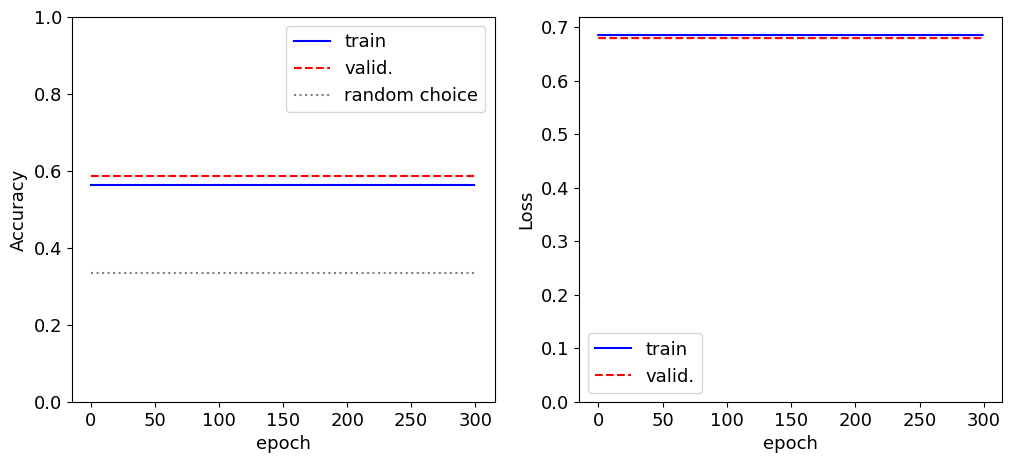

In [30]:

def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

Show_history(fit)

In [36]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
N_range=[0.2,0.4,0.6,0.8]
val_accuracies=[]
svm_val_accuracies=[]
knn_val_accuracies=[]
xgb_val_accuracies=[]


for N1 in N_range:
    #split the dataset
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=N1, random_state=42)
    #CNN
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS, validation_data=(x_val,y_val), verbose=0, shuffle=True)
    val_accuracy = fit.history['val_accuracy'][-1]
    #SVM
    feature_mapping=model(x_val)
    svm_classifier = SVC()
    svm_classifier.fit(feature_mapping, y_val)
    svm_val_accuracy = accuracy_score(y_val, svm_classifier.predict((feature_mapping)))
    #kNN
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(feature_mapping, y_val)
    knn_val_accuracy = accuracy_score(y_val, knn_classifier.predict((feature_mapping)))
    #XGBoost
    model_xgb = XGBClassifier(seed=1,
                      objective='binary:logistic',
       # importance_type="gain" #weight, cover, ...
       learning_rate=0.1,
       reg_lambda=0.1, reg_alpha=0.01,
       n_estimators=150, max_depth=6, gamma=0)

    model_xgb.fit(x_train, y_train)
    y_val_pred = model_xgb.predict(x_val)
    xgb_val_accuracy = accuracy_score(y_val, y_val_pred)


    xgb_val_accuracies.append(xgb_val_accuracy)
    val_accuracies.append(val_accuracy)
    svm_val_accuracies.append(svm_val_accuracy)
    knn_val_accuracies.append(knn_val_accuracy)

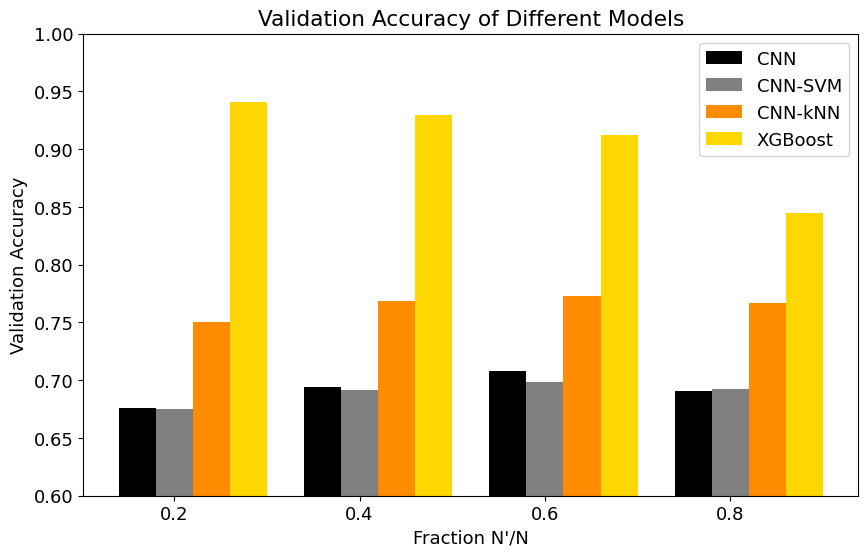

In [37]:
# Plot histogram of validation accuracies
models = ['CNN', 'CNN-SVM', 'CNN-kNN', 'XGBoost']  
color=["black","gray","darkorange","gold"]
Nrange=["0.2","0.4","0.6","0.8"]
accuracies = [val_accuracies, svm_val_accuracies, knn_val_accuracies, xgb_val_accuracies] 
plt.figure(figsize=(10, 6))

# Plot bar chart for each model
for i, (model, acc) in enumerate(zip(models, accuracies)):
    plt.bar(np.arange(len(models)) + i * 0.2, acc, width=0.2, color=color[i], label=model)

# Add labels and title
plt.xlabel('Fraction N\'/N')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy of Different Models')
plt.ylim(0.6, 1)
plt.xticks(np.arange(len(models)) + 0.2, Nrange)
plt.legend()

plt.show()

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Initialize lists to store accuracy scores
val_accuracies = []
svm_val_accuracies = []
knn_val_accuracies = []
xgb_val_accuracies = []

# Define number of folds for cross-validation
k = 5
N_range=[0.2,0.4,0.6,0.8]

# Initialize KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)
model=build_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# Loop through different test sizes
for N1 in N_range:
    # Split the dataset into training and testing sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=N1, random_state=42)

    # Initialize lists to store accuracy scores for each fold
    fold_val_accuracies = []
    fold_svm_val_accuracies = []
    fold_knn_val_accuracies = []
    fold_xgb_val_accuracies = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(x_train):
        x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Train and evaluate CNN model
        
        fit = model.fit(x_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test_fold, y_test_fold), verbose=0, shuffle=True)
        fold_val_accuracy = fit.history['val_accuracy'][-1]
        fold_val_accuracies.append(fold_val_accuracy)

        # Train and evaluate SVM model
        svm_classifier = SVC()
        svm_classifier.fit(x_train_fold, y_train_fold)
        fold_svm_val_accuracy = accuracy_score(y_test_fold, svm_classifier.predict(x_test_fold))
        fold_svm_val_accuracies.append(fold_svm_val_accuracy)

        # Train and evaluate kNN model
        knn_classifier = KNeighborsClassifier()
        knn_classifier.fit(x_train_fold, y_train_fold)
        fold_knn_val_accuracy = accuracy_score(y_test_fold, knn_classifier.predict(x_test_fold))
        fold_knn_val_accuracies.append(fold_knn_val_accuracy)

        # Train and evaluate XGBoost model
        model_xgb = XGBClassifier(seed=1,
                                  objective='binary:logistic',
                                  learning_rate=0.1,
                                  reg_lambda=0.1,
                                  reg_alpha=0.01,
                                  n_estimators=150,
                                  max_depth=6,
                                  gamma=0)
        model_xgb.fit(x_train_fold, y_train_fold)
        fold_xgb_val_accuracy = accuracy_score(y_test_fold, model_xgb.predict(x_test_fold))
        fold_xgb_val_accuracies.append(fold_xgb_val_accuracy)

    # Average accuracy scores across folds
    val_accuracies.append(np.mean(fold_val_accuracies))
    svm_val_accuracies.append(np.mean(fold_svm_val_accuracies))
    knn_val_accuracies.append(np.mean(fold_knn_val_accuracies))
    xgb_val_accuracies.append(np.mean(fold_xgb_val_accuracies))

c:\Users\primo\OneDrive\Desktop\physics of data\Lab. of Computational Physics (Mod. B)\Ex3\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


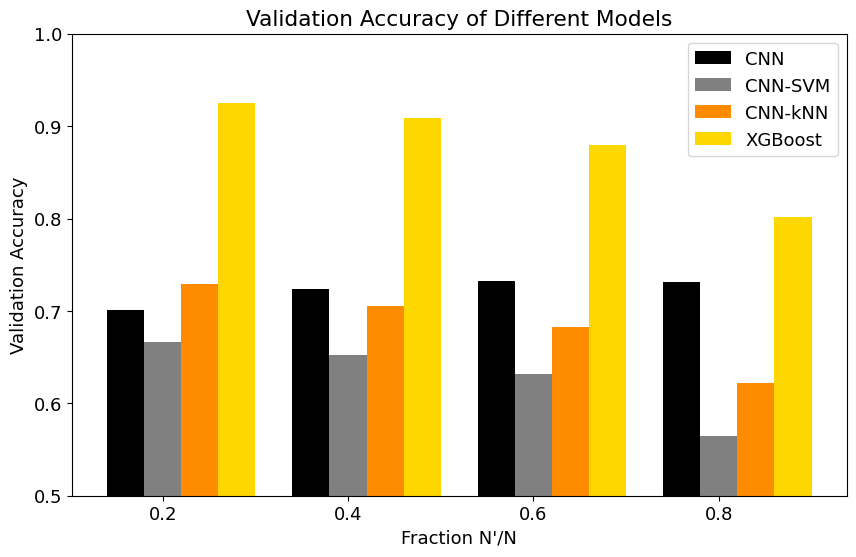

In [41]:
# Plot histogram of validation accuracies
models = ['CNN', 'CNN-SVM', 'CNN-kNN', 'XGBoost']  
color=["black","gray","darkorange","gold"]
Nrange=["0.2","0.4","0.6","0.8"]
accuracies = [val_accuracies, svm_val_accuracies, knn_val_accuracies, xgb_val_accuracies] 
plt.figure(figsize=(10, 6))

# Plot bar chart for each model
for i, (model, acc) in enumerate(zip(models, accuracies)):
    plt.bar(np.arange(len(models)) + i * 0.2, acc, width=0.2, color=color[i], label=model)

# Add labels and title
plt.xlabel('Fraction N\'/N')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy of Different Models')
plt.ylim(0.5, 1)
plt.xticks(np.arange(len(models)) + 0.2, Nrange)
plt.legend()

plt.show()